# 5008 Project

In [7]:
import pandas as pd

# fb-pages-media.edges is too large for my computer (waiting for testing)
df = pd.read_csv("dataset/fb-pages-food.edges", names=["node_1", "node_2"]) 
df['attr'] = "solid"
df.head(10)

,node_1,node_2,attr
0,0,276,solid
1,0,58,solid
2,0,132,solid
3,0,603,solid
4,0,398,solid
5,0,555,solid
6,1,265,solid
7,1,611,solid
8,2,265,solid
9,2,182,solid


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec

# transform dataframe to networkx object
graph = nx.from_pandas_edgelist(df, "node_1", "node_2", "attr")

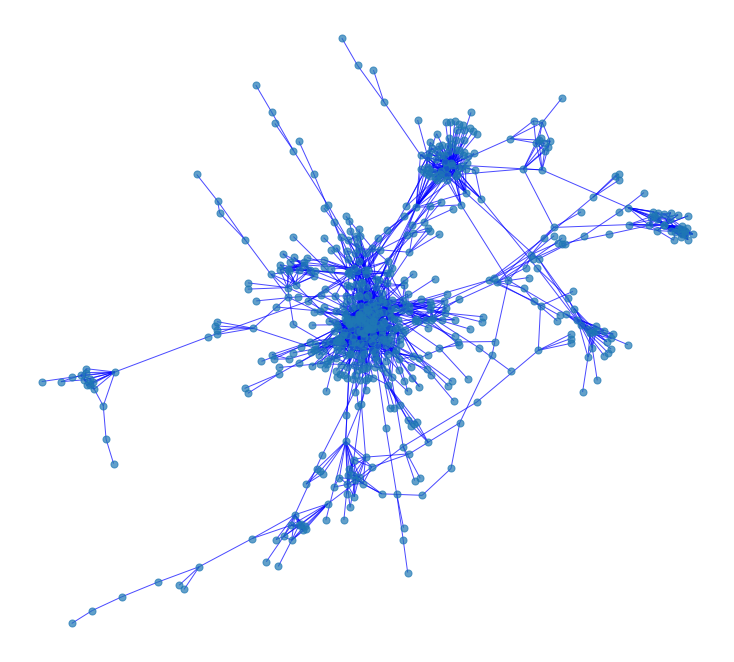

In [17]:
plt.figure(figsize=(10,9))
nx.draw(graph, with_labels=False, node_size=50, alpha=0.7, edge_color='b')

In [18]:
num_nodes = graph.number_of_nodes() # the number of nodes
num_edges = graph.number_of_edges() # the number of edges
print("num_nodes = ", num_nodes)
print("num_edges = ", num_edges)

num_nodes =  620
num_edges =  2102


## 1 Find edges which can be removed from original graph

When removing the edge, we should make sure that the graph is connected and no redution in the number of nodes. In this step, we store all the omissiable edges in list `omissible_edges` and remove the edges from the original graph.

In [19]:
import numpy as np

rnd = np.random.RandomState()
edges_index = rnd.permutation(num_edges) # generate a permutation array from 0 to num_edges
edges = list(graph.edges())
omissible_edges = list() # the edges that can be removed
t = 0

# Traversal all edges
# If using fb-pages-media.edges, there are totally 206259 edges so it'll take some time to traversal all edges, about 30 min for my computer
for i in edges_index:
    edge = edges[i]
    node_1 = edge[0]
    node_2 = edge[1]
    
    if t % 500 == 0:
        print("processing: %s/%s" %(t,num_edges))
    
    graph.remove_edge(*edge)
    reachable_from_node_1 = nx.connected._plain_bfs(graph, node_1)
    
    if node_2 not in reachable_from_node_1:
        # the drop would make the graph become unconnected or reduce the number of nodes
        # so we shouldn't drop this edge, re-adding the edge
        graph.add_edge(*edge)
    else:
        # the edge is omissible and as a positive sample
        omissible_edges.append(edge)
    t += 1

processing: 0/2102
processing: 500/2102
processing: 1000/2102
processing: 1500/2102
processing: 2000/2102


In [21]:
num_omissible_edges = len(omissible_edges)
print("num_omissible_edges = ", num_omissible_edges)

num_omissible_edges =  1483


In [22]:
for index,row in df.iterrows():
    if ((row['node_1'], row['node_2']) in omissible_edges) or ((row['node_2'], row['node_1']) in omissible_edges):
        df.loc[index,'attr'] = 'dashdot'

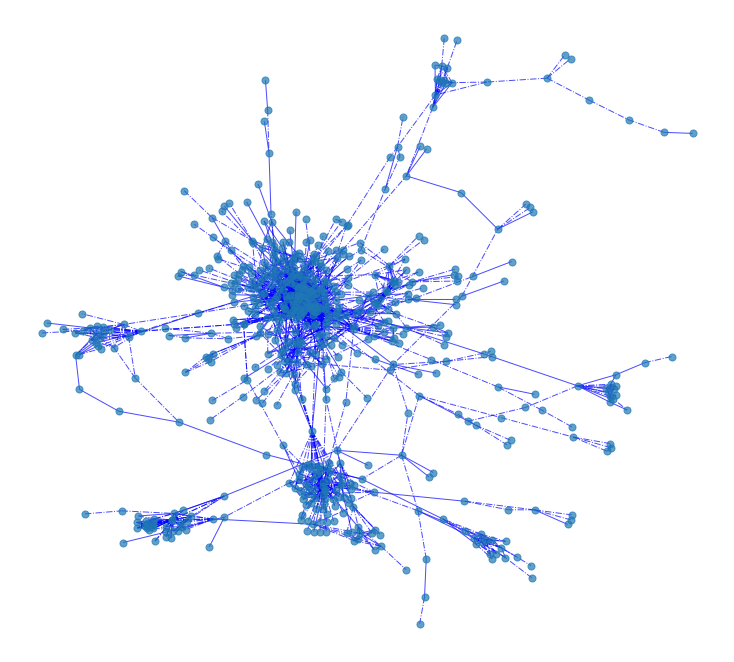

In [14]:
graph_show_omissible = nx.from_pandas_edgelist(df, "node_1", "node_2", "attr")
plt.figure(figsize=(10,9))
nx.draw(graph_show_omissible, with_labels=False, node_size=50, alpha=0.7, edge_color='b', style=df['attr'])

In [23]:
num_edges_pro = graph.number_of_edges()
num_nodes_pro = graph.number_of_nodes()
print("num_edges after processing = ", num_edges_pro)
print("num_nodes after processing = ", num_nodes_pro)

num_edges after processing =  619
num_nodes after processing =  620


## 2 Implement node2vec on the graph which has been removed some edges

In [24]:
from node2vec import Node2Vec

# Precompute probabilities and generate walks
node2vec = Node2Vec(graph, dimensions=128, walk_length=30, num_walks=200, workers=2)

# Embbed nodes
# If using fb-pages-media.edges, the training time is about 10 min for my computer
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|█████████████████████████████████████████| 620/620 [00:00<00:00, 12190.29it/s]


In [25]:
# Save embeddings for later use
# model.wv.save_word2vec_format("model/node2vec.wv")

# Save model for later use
model.save("model/node2vec_small.model")

In [31]:
# Load model

# from gensim.models import Word2Vec
# Word2Vec.load("model/node2vec_small.model")

In [33]:
node_vec = model.wv
#node_vec["0"]

In [45]:
X = model.wv.vectors

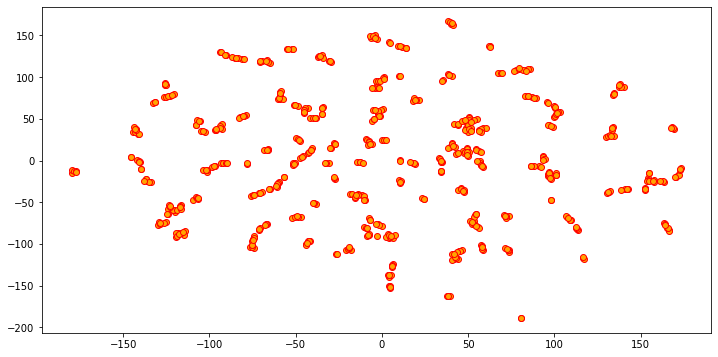

In [49]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(X)

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')

## 3 Generate positive samples and negative samples

HadamardEmbedder is used to embed edges, train and do link prediction.

In [56]:
from node2vec.edges import HadamardEmbedder

# Generate the edges embeddings i.e. using vector to express edge
edges_embs = HadamardEmbedder(keyed_vectors=node_vec)
#edges_embs[("0", "1")] # The vector of edge from node 0 to node 1

In [59]:
X_pos = [edges_embs[str(i), str(j)] for i,j in omissible_edges]
y_pos = [1] * len(X_pos)

In [53]:
# Create the adjacency matrix of graph
crosstab = pd.crosstab(df.node_1, df.node_2)
idx = crosstab.columns.union(crosstab.index)
adjmat = crosstab.reindex(index=idx, columns=idx, fill_value=0)
adjmat = adjmat.values.T + adjmat.values

In [112]:
# Compute the number of following myself
#num_follow_myself = 0
#for i in range(num_nodes):
#    for j in range(num_nodes):
#        if adjmat[i][j] == 2 and i == j:
#            num_follow_myself += 1
# num_follow_myself

As you can see, it is a square matrix. Now, we will traverse the adjacency matrix to find the positions of the zeros. Please note that we don’t have to go through the entire matrix. The values in the matrix are the same above and below the diagonal, as you can see below:

![adjacency matrix](img/adjmat.webp)

We can either search through the values above the diagonal (green part) or the values below (red part). Let’s search the **values above the diagonal** for zero:

In [54]:
unconnected_edges = list()
# Only search the green part i.e. values above the diagonal to find all unconnected edges
for i in range(0, num_nodes):
    if i % 50 == 0:
        print("processing: %s/%s" % (i,num_nodes))
    for j in range(i+1, num_nodes):
        if adjmat[i][j] == 0:
            unconnected_edges.append((i,j))

processing: 0/620
processing: 50/620
processing: 100/620
processing: 150/620
processing: 200/620
processing: 250/620
processing: 300/620
processing: 350/620
processing: 400/620
processing: 450/620
processing: 500/620
processing: 550/620
processing: 600/620


In [61]:
# Generate nagtive samples
X_neg = []
y_neg = []
for i in range(0, len(unconnected_edges)):
    X_neg.append(edges_embs[str(unconnected_edges[i][0]), str(unconnected_edges[i][1])])
    y_neg.append(0)

In [62]:
X = X_pos + X_neg
y = y_pos + y_neg

print("number of X positive = ", len(X_pos))
print("number of X negtive = ", len(X_neg))
print("number of X = ", len(X))

number of X positive =  1483
number of X negtive =  189799
number of X =  191282


## Oversample and Split Validation

In [121]:
# Over Sampling to deal with unbalanced data problem
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)

In [159]:
import time
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=int(time.time()))

In [160]:
print("X_resampled number = %s" % len(X_resampled))
print("y_resampled number = %s" % len(y_resampled))
print("X_train number = %s" % len(X_train))
print("y_train number = %s" % len(y_train))
print("X_val number = %s" % len(X_val))
print("y_val number = %s" % len(y_val))

X_resampled number = 379598
y_resampled number = 379598
X_train number = 303678
y_train number = 303678
X_val number = 75920
y_val number = 75920


## 4 Link prediction

In [135]:
from sklearn import metrics

In [161]:
def generate_csv(path, clf, num_nodes):
    
    output = []

    for i in range(0, num_nodes):
        for j in range(i+1, num_nodes):
            pred_label = clf.predict([edges_embs[str(i), str(j)]])
            prob = clf.predict_proba([edges_embs[str(i), str(j)]])
            if pred_label == 1:
                output.append([i, j, prob[0][0], prob[0][1]])
        if i%100 == 0:
            print("nodes: %s/%s" % (i, num_nodes))
                
    output_df = pd.DataFrame(columns=['node_1', 'node_2', 'negative prob', 'positive prob'], data=output)
    output_df.to_csv(path, index=False)

### 4.1 Logistic Regression Model

In [162]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [164]:
y_pred = lr.predict(X_val)

print("Accuracy = %s" % metrics.accuracy_score(y_val, y_pred))
print("F1 = %s" % metrics.f1_score(y_val, y_pred, average="macro"))

Accuracy = 0.7150421496311907
F1 = 0.7140730078982507


In [165]:
generate_csv("outputs_small/lr_links_pred.csv", lr, num_nodes)

nodes: 0/620
nodes: 100/620
nodes: 200/620
nodes: 300/620
nodes: 400/620
nodes: 500/620
nodes: 600/620


### 4.2 LightGBM Classifier

In [166]:
# LightGBM Classifier
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=10, learning_rate=1e-2, n_estimators=100)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [167]:
y_pred = lgbm.predict(X_val)

print("Accuracy = %s" % metrics.accuracy_score(y_val, y_pred))
print("F1 = %s" % metrics.f1_score(y_val, y_pred, average="macro"))

Accuracy = 0.870113277133825
F1 = 0.8700547659294263


In [168]:
generate_csv("outputs_small/lgbm_links_pred.csv", lgbm, num_nodes)

nodes: 0/620
nodes: 100/620
nodes: 200/620
nodes: 300/620
nodes: 400/620
nodes: 500/620
nodes: 600/620


### 4.3 Random Forest Classifier

In [169]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [170]:
y_pred = rf.predict(X_val)

print("Accuracy = %s" % metrics.accuracy_score(y_val, y_pred))
print("F1 = %s" % metrics.f1_score(y_val, y_pred, average="macro"))

Accuracy = 0.9990648050579557
F1 = 0.9990648049993829


In [171]:
generate_csv("outputs_small/rf_links_pred.csv", rf, num_nodes)

nodes: 0/620
nodes: 100/620
nodes: 200/620
nodes: 300/620
nodes: 400/620
nodes: 500/620
nodes: 600/620


Testing on the `fb-pages-food` dataset

| Model | Accuracy | F1 scores |
|------|:-----------:|:-----------:|
| Logistic Regression | 0.775 | 0.714 |
| LightGBM | 0.870 | 0.870 |
| Random Forest | 0.999 | 0.999 |